# Machine Learning: Exercise session 07

In this exercise session we will focus on tree bagging and random forests for the practical parts.

The theoretical exercise is about the properties of bootstrap. We will derive the probability that a given observation is part of a bootstrap sample.

## 0. Data import and Cleaning

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ParameterGrid

In [6]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + "\\general_python_scripts") #need to add folder "general_python_scripts" to path to be able to import following module


In [105]:
def change_to_cat(my_df,threshold = 5):
    '''
    function that takes a dataframe and an integer
    and outputs a two-list containging:
    a copy of the dataframe with column types changed to "category" if the amount of different values is lower or equal to the integer
    a dataframe containing all the unique values from original dataframe
    '''
    temp_df = my_df.copy()
    
    #creation of copy with types changed to "category"
    cat_var = [col for col in temp_df.columns if ( (len(temp_df[col].unique()) <= threshold) or (temp_df[col].dtype=='O') )]  
    temp_df[cat_var]=temp_df[cat_var].astype("category")

    #creation of the df with unique values only
    temp_df_unique = pd.DataFrame.from_dict({var : sorted(list(temp_df[var].unique()), key= lambda x: str(x)) for var in cat_var}, orient='index').T
    return [temp_df,temp_df_unique]

Import the "Heart" dataset, containing demographic and medical informations about a list of patients. Drop `NA` values, convert the categorical variables into the desired pandas type: "category", and perform any other necessary data cleaning.

In [106]:
heart_df = pd.read_csv('Heart_ISL.csv').dropna().drop("Unnamed: 0", axis = 1)

In [107]:
heart_df, categories = change_to_cat(heart_df)

In [112]:
heart_df

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,asymptomatic,140,241,0,0,123,1,0.2,2,0.0,reversable,Yes
298,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
299,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
300,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes


In [111]:
categories

,Sex,ChestPain,Fbs,RestECG,ExAng,Slope,Ca,Thal,AHD
0,0,asymptomatic,0,0,0,1,0.0,fixed,No
1,1,nonanginal,1,1,1,2,1.0,normal,Yes
2,None,nontypical,None,2,None,3,2.0,reversable,None
3,None,typical,None,None,None,None,3.0,None,None


In [132]:
X_1 = pd.get_dummies(heart_df.drop(["AHD"],axis=1),drop_first=True)
y_1 = heart_df['AHD']

Split the data into train and test. Set random_state=40 and leave 20% of the data out for the test set.

In [133]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, shuffle = True, random_state = 40)

## 1. Bagging and Random Forests

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

### 1.1 Forest of trees

Fit a random forest, with 200 trees and default values for the other hyper-parameters, to the heart dataset. Then plot three of the forest's trees.

Then do the same for a tree bagging model. What is the only hyper-parameter to change in the `RandomForestClassifier` to obtain a tree bagging model?

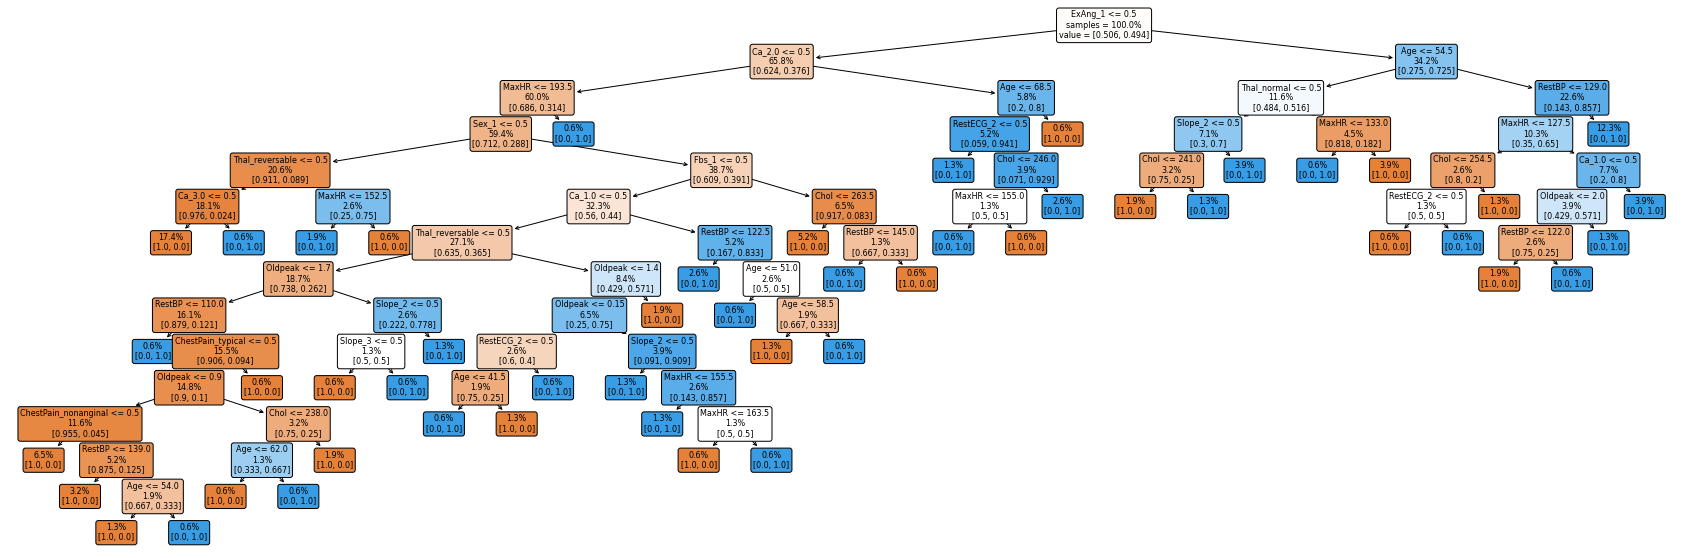

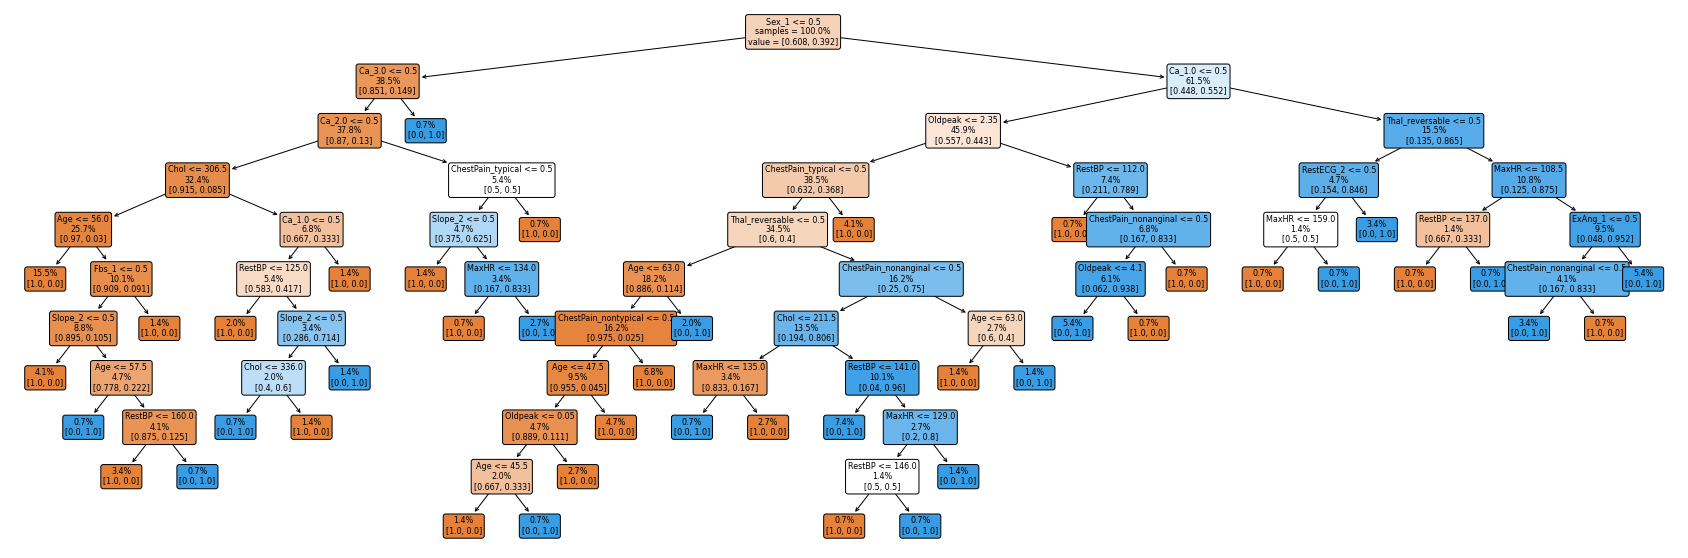

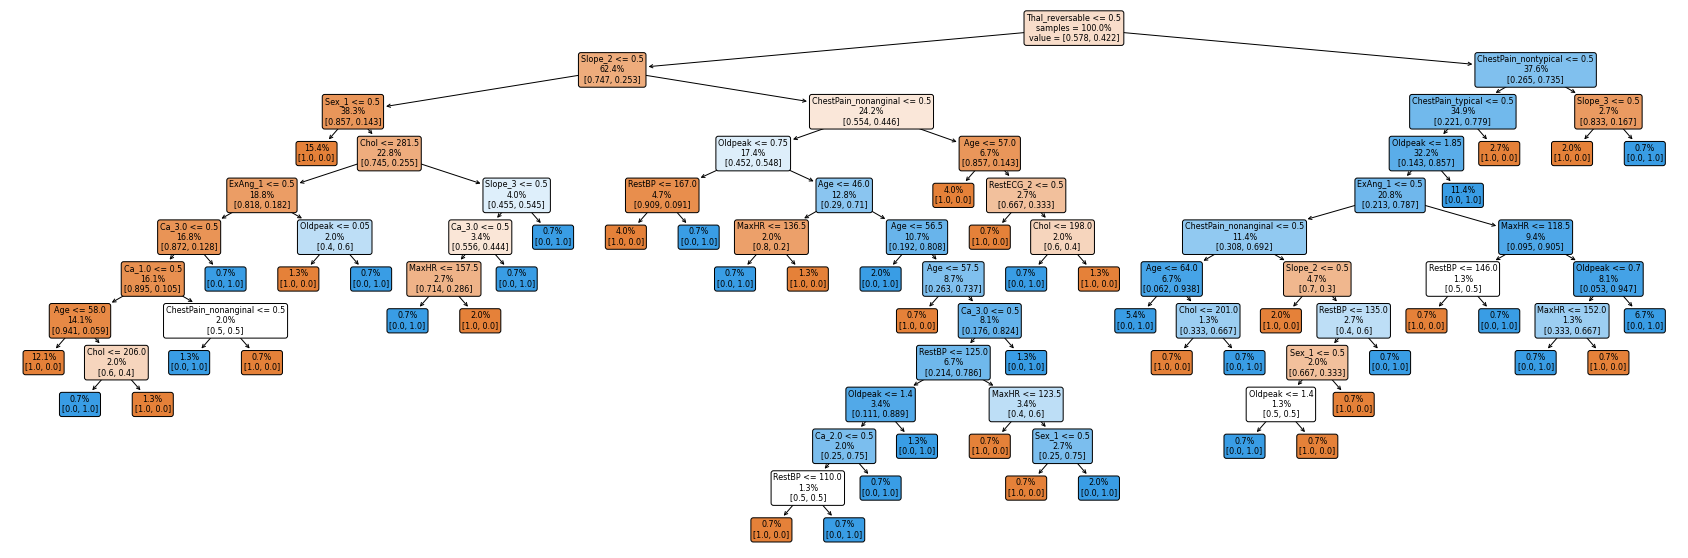

In [142]:
forest = RandomForestClassifier(n_estimators = 200)
forest.fit(X_1_train, y_1_train)
for i in range(3):
    plt.figure(figsize = (30,10))
    plot_tree(forest.estimators_[i], feature_names=X_1.columns.tolist(), impurity=False, label="root",
filled=True, proportion=True, rounded=True, fontsize=8)
    plt.show()

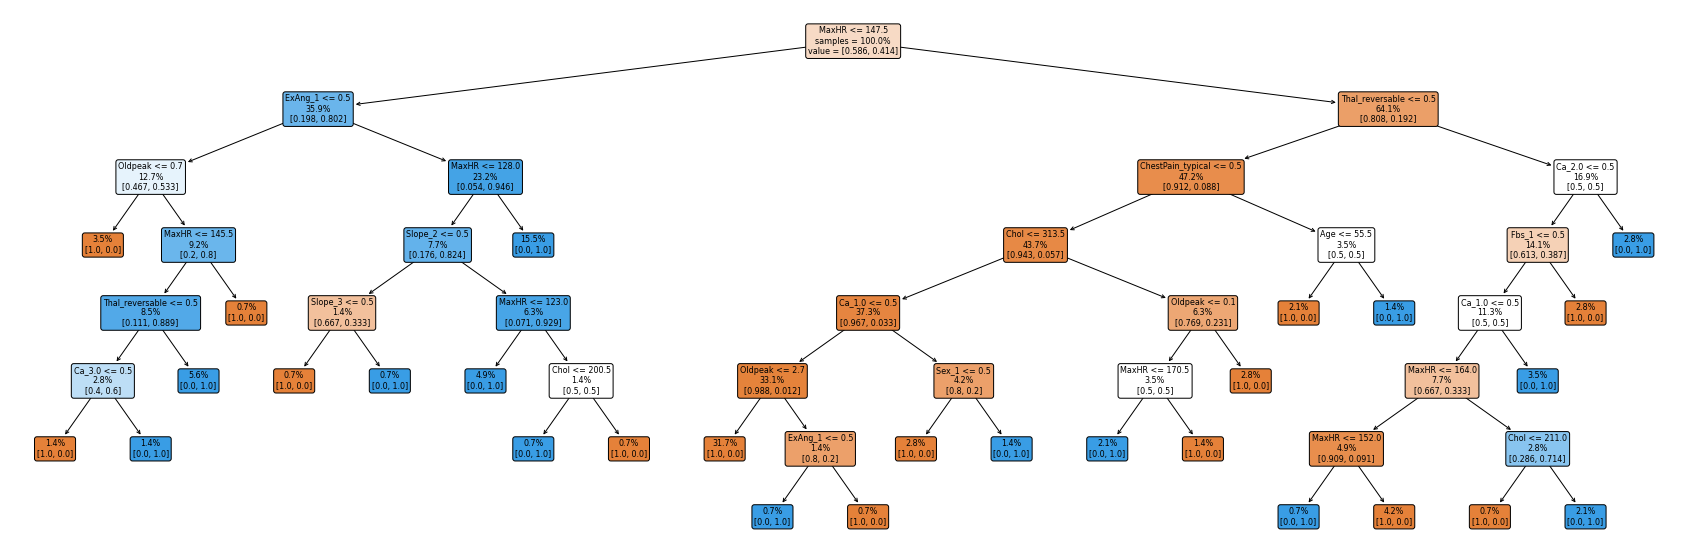

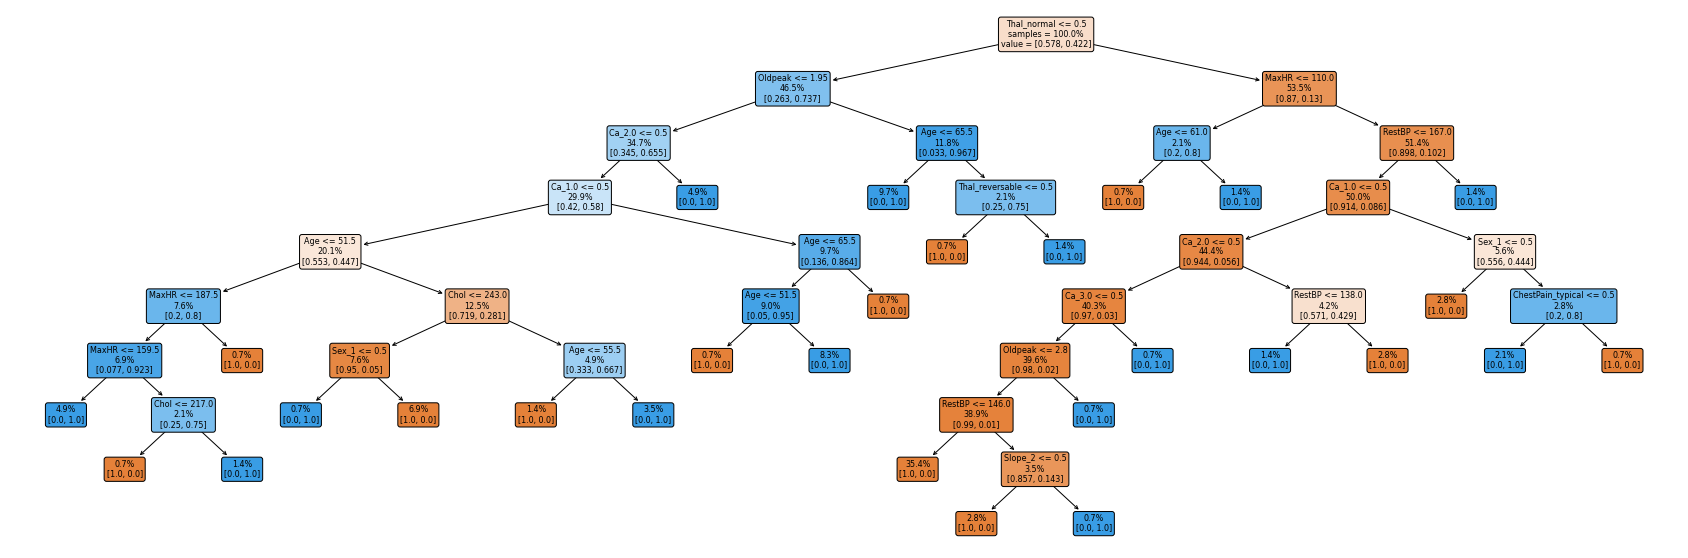

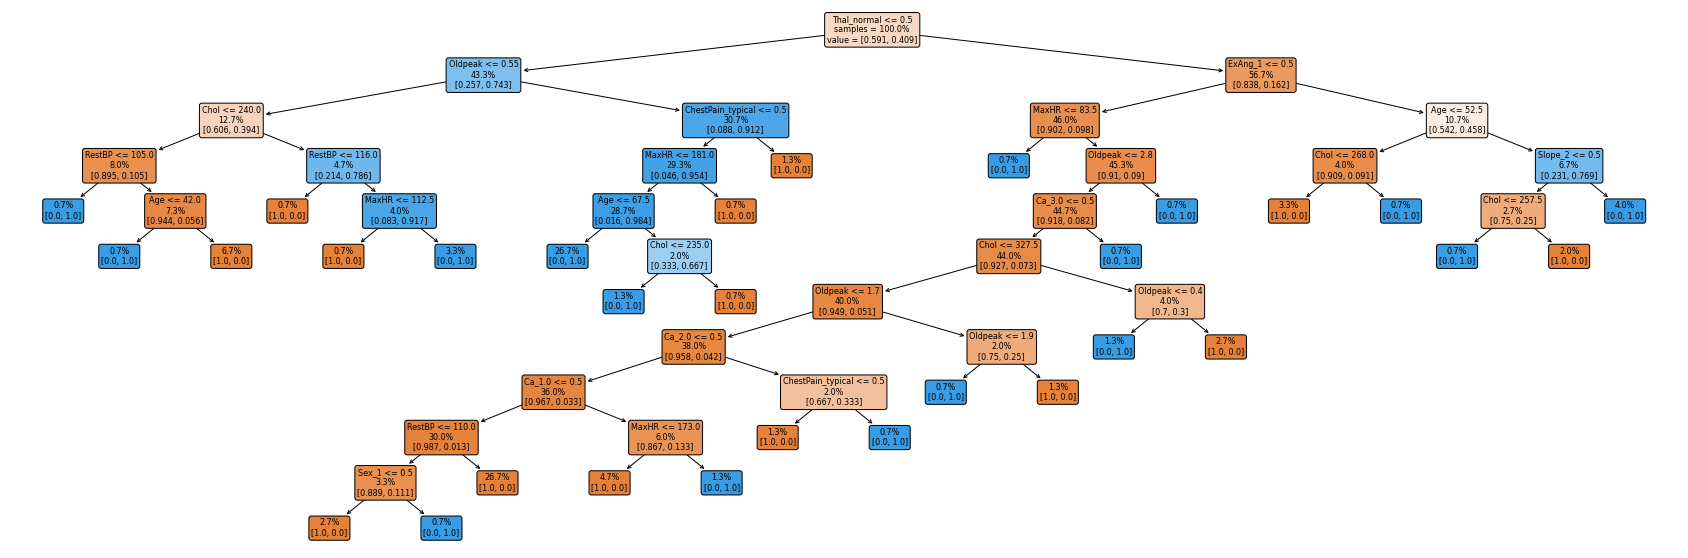

In [143]:
bagging = RandomForestClassifier(n_estimators = 200, max_features = None)
bagging.fit(X_1_train, y_1_train)
for i in range(3):
    plt.figure(figsize = (30,10))
    plot_tree(bagging.estimators_[i], feature_names=X_1.columns.tolist(), impurity=False, label="root",
filled=True, proportion=True, rounded=True, fontsize=8)
    plt.show()

### 1.2 Tune the Forest

Now tune the hyper-parameters "max_features" and "min_samples_leaf" of the Random Forest classifier to minimize the expected generalization error.

You could use cross-validation. Is there another way to get the desired estimate other than with cross-validation? Use 2000 trees per forest or more.

_Hint:_ `sklearn.model_selection.ParameterGrid` and `<RF_instance>.set_params(...)` might be useful.

_Tip:_ In sklearn, you can set `n_jobs=-1` (or `n_jobs=-2`) in some models and in grid searches to use all (or all but one) of your computer's cores in parallel, which can reduce the running time depending on your computer. Be careful not to "nest" the parallelization.

In [180]:
# trying some stuff, CV waaaay too slow for good amount of param: n_estimators = 2000, num = 100. here with 20 and 20 we wait 3 minutes 35, with unsatsfying result of max_features=2 and min_samples_leaf=1
forest = RandomForestClassifier(n_estimators = 20, oob_score=True)
features_grid = [k+1 for k in range(len(X_1.columns))]
leaf_grid = [int(k) for k in np.linspace(1, len(X_1), num = 20)]
forest_cv = GridSearchCV(
    estimator=forest,
    param_grid={"max_features": features_grid, "min_samples_leaf" : leaf_grid},
    scoring="accuracy",
    cv=10,
)
forest_cv.fit(X_1_train,y_1_train)


C:\Users\vicki_la_tombe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\vicki_la_tombe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\vicki_la_tombe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\vicki_la_tombe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB est

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=20, oob_score=True),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20],
                         'min_samples_leaf': [1, 16, 32, 47, 63, 78, 94, 110,
                                              125, 141, 156, 172, 187, 203, 219,
                                              234, 250, 265, 281, 297]},
             scoring='accuracy')

In [182]:
pd.DataFrame(forest_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056047,0.012589,0.004989,0.001094,1,1,"{'max_features': 1, 'min_samples_leaf': 1}",0.875000,0.750000,0.791667,0.875000,0.750000,0.833333,0.625000,0.826087,0.956522,0.608696,0.789130,0.104236,7
1,0.046881,0.008440,0.005183,0.001982,1,16,"{'max_features': 1, 'min_samples_leaf': 16}",0.875000,0.625000,0.875000,0.708333,0.708333,0.791667,0.666667,0.782609,0.695652,0.652174,0.738043,0.084371,60
2,0.040691,0.002387,0.005285,0.001728,1,32,"{'max_features': 1, 'min_samples_leaf': 32}",0.750000,0.666667,0.750000,0.750000,0.708333,0.666667,0.625000,0.695652,0.826087,0.695652,0.713406,0.054365,88
3,0.043310,0.004518,0.005185,0.002176,1,47,"{'max_features': 1, 'min_samples_leaf': 47}",0.791667,0.541667,0.791667,0.666667,0.708333,0.541667,0.583333,0.739130,0.565217,0.695652,0.662500,0.093483,98
4,0.034704,0.001323,0.004295,0.001004,1,63,"{'max_features': 1, 'min_samples_leaf': 63}",0.750000,0.541667,0.666667,0.541667,0.541667,0.541667,0.583333,0.565217,0.565217,0.565217,0.586232,0.065244,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.049567,0.008046,0.006178,0.002125,20,234,"{'max_features': 20, 'min_samples_leaf': 234}",0.541667,0.541667,0.541667,0.541667,0.541667,0.541667,0.583333,0.565217,0.565217,0.565217,0.552899,0.014624,101
396,0.058099,0.027968,0.008177,0.001820,20,250,"{'max_features': 20, 'min_samples_leaf': 250}",0.541667,0.541667,0.541667,0.541667,0.541667,0.541667,0.583333,0.565217,0.565217,0.565217,0.552899,0.014624,101
397,0.044972,0.003772,0.006191,0.002848,20,265,"{'max_features': 20, 'min_samples_leaf': 265}",0.541667,0.541667,0.541667,0.541667,0.541667,0.541667,0.583333,0.565217,0.565217,0.565217,0.552899,0.014624,101
398,0.063232,0.024085,0.005783,0.001068,20,281,"{'max_features': 20, 'min_samples_leaf': 281}",0.541667,0.541667,0.541667,0.541667,0.541667,0.541667,0.583333,0.565217,0.565217,0.565217,0.552899,0.014624,101


In [ ]:
list(ParameterGrid({"max_features" : leaf_grid, "min_samples_leaf" :features_grid}))

_Remark:_ When comparing the Random Forest performance with other models, it is better to use cross-validation error estimates, so that the estimates are comparable between models.

### 1.3. Model Diagnostic

Consider the best random forest model from cross-validation. We now want to use different metrics to evaluate the model performance on the test set.

First, install the `yellowbrick` package with `pip install yellowbrick` (https://www.scikit-yb.org/en/latest/).

Perform a classification report using the `classification_report()` function from `yellowbrick` and comment the results.

Plot the confusion matrix using the `confusion_matrix()` function from `yellowbrick`.

Plot the Receiver Operating Characteristic (ROC) using the `roc_auc` from `yellowbrick`.

## 3. Theoretical Exercise: Properties of Bootstrap

**This part does not need to be handed in.**

We will now derive the probability that a given observation is part
of a bootstrap sample. 

Let $Z = \{Z_1, \dots, Z_n\}$ be our original sample of size $n$. (For example, $Z_i = (X_i, Y_i)$
can represent the pair of predictors and target variables for each observation $i = 1, \dots, n$.)

Let $Z^* = \{Z_1^*, \dots, Z_n^*\}$ be a bootstrap sample of size $n$, resampled from $Z$. (You can think of it as one of the $B$ bootstrap samples $Z^{*1},\ldots,Z^{*B}$ used for bagging.)

We want to show that, for each $i = 1, \dots, n$, the probability that $Z_i$ is part of the bootstrap sample is $P\left(Z_i \in Z^*\right) = 1 - 1/e$.

* What is the probability that the first bootstrap observation
is not the $i$-th observation from the original sample? 
Justify your answer.

*$\frac{n-1}{n}=1-\frac{1}{n}$*

* What is the probability that the second bootstrap observation
is not the $i$-th observation from the original sample?

*Also $1-\frac{1}{n}$*

* Argue that the probability that the $i$-th observation is not in the
bootstrap sample is $(1 - \frac{1}{n})^n$.

$$P(z_i\not\in Z_i^*)=P\left(\bigcap _{j=1}^nz_i\neq x_j\right)\underbrace{=}_{\text{by independence}}\prod_{j=1}^nP(z_i\neq x_j)=\left(1-\frac{1}{n}\right)^n$$

* When $n = 5$, what is the probability that the $i$-th observation is
in the bootstrap sample?

$1-(1-\frac{1}{5})^5\approx 0.672$

* When $n = 100$, what is the probability that the $i$-th observation
is in the bootstrap sample?

$1-(1-\frac{1}{100})^{100}\approx 0.634$

* When $n \to \infty$, what is the probability that the $i$-th observation
is in the bootstrap sample?

$\lim_{n\rightarrow\infty}(1-\frac{1}{n})^n=1-\frac{1}{e}\approx 0.632$